<h1><center>Laboratorio 8: Aprendizaje Supervisado 🔮</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Pablo Badilla y Ignacio Meza
- Auxiliar: Sebastián Tinoco
- Ayudante: Felipe Arias y Diego Cortez

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Lennin Chamorro
- Nombre de alumno 2: Martin Reyes


### **Link de repositorio de GitHub:** `https://github.com/Landilus/Lab_prog_cientifica`

## Temas a tratar

- Aprendizaje Supervisado
- Flujos de datos a través de `Pipelines`.

## Reglas

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.

## Objetivos principales del laboratorio

- Comprender el funcionamiento de clasificadores/regresores.
- Generar múltiples modelos predictivos.
- Comprender las ventajas de crear modelos en pipeline vs hacer las operaciones a mano.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre `DataFrames`.

### Importamos librerias utiles 😸

In [1]:
# Libreria Core del lab.
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split 

# Pre-procesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

# Metricas de evaluación
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

#Libreria para plotear
!pip install --upgrade plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


https://www.kaggle.com/antoinekrajnc/soccer-players-statistics

# 1. Predicciones Futboleras

<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1BnO4tyh3vM2P199Ec9s3JjngQ4qQ9seP"
" width="300">
</p>


Tras el trágico despido de la mítica mascota de Maipú, Renacín decide adentrarse como consultor en el mercado futbolero, el cuál (para variar...) está cargado en especulaciones. 

Como su principal tarea será asesorar a los directivos de los clubes sobre cuál jugador comprar y cuál no, Renacín desea generar modelos predictivos que evaluén distintas características de los jugadores; todo con el fin de tomar decisiones concretas basadas en los datos.

Sin embargo, su condición de corporeo le impidió tomar la versión anterior de MDS7202, por lo que este motivo Renacín contrata a su equipo para lograr su objetivo final. Dado que aún tiene fuertes vínculos con la dirección de deportes de la municipalidad, el corporeo le entrega base de datos con las estadísticas de cada jugador para que su equipo empieze a trabajar ya con un dataset listo para ser usado.


**Los Datos**

Para este laboratorio deberán trabajar con los csv `statsplayers.csv` y `salarios.pickle`, donde deberán aplicar algoritmos de de aprendizaje supervisado (clasificación y regresión) en base a características que describen de jugadores de futbol.

Para comenzar cargue el dataset señalado y a continuación vea el reporte **`Player_Stats_Report.html`** (adjunto en la carpeta del enunciado) que describe las características principales del `DataFrame`.

In [2]:
# Si usted está utilizando Colabolatory le puede ser útil este código para cargar los archivos.
#try:
#    from google.colab import drive
#    drive.mount("/content/drive")
#    path = 'Dirección donde tiene los archivos en el Drive'
#except: 
#    print('Ignorando conexión drive-colab')

In [62]:
df_players = pd.read_csv('/content/stats_players.csv')
df_players['National_Position'] = df_players['National_Position'].apply(lambda x: 0 if pd.isnull(x) else 1)
df_players = df_players.astype(
    {
        "Nationality": "category",
        "National_Position": "category",
        "Club_Position": "category",
        "Preffered_Foot": "category",
        "Work_Rate": "category"
    }
)
print(f'En el dataframe hay {df_players.isnull().sum().sum()} valores nulos')
print(f'En el dataframe hay {df_players.duplicated().sum()} datos duplicados')

En el dataframe hay 1 valores nulos
En el dataframe hay 0 datos duplicados


In [63]:
df_players = df_players.dropna()

## 1.1 Predicción de Seleccionados Nacionales 

Como primera tarea, Renacín, intrigado por la posibilidad de saber qué tan reconocido es un jugador, le consulta a su equipo si es posible predecir si un jugador será o no seleccionado nacional a partir de sus estadísticas en el juego. 

<p align="center">
  <img src="https://thumbs.gfycat.com/ThornyFrankFoxhound-size_restricted.gif" width="500">
</p>

### 1.1.1 Generación de Labels para la Clasificación [Sin Puntaje]


Primero comience generando las labels para la clasificación. Para esto, trabaje sobre el atributo ```National_Position``` suponiendo que los valores nulos son jugadores no seleccionados para representar a su país. 

Hecho esto, ¿Cuantos ejemplos por cada clase se tienen? Comente lo que observa.



**Respuesta:**

In [64]:
df_players['National_Position'].value_counts()

0    16512
1     1075
Name: National_Position, dtype: int64

Vemos que las categorias estan desbalanceadas, hay muchos más jugadores No seleccionados que Jugadores Seleccioandos. Esto era de esperarse, ya que sólo un pequeño grupo de todos los jugadores profesionales es seleccionado para representar a su pais.

### 1.1.2 Camino a la clasificación [1 punto]

<p align="center">
  <img src="https://c.tenor.com/SoXZJHWnhKAAAAAC/pitbull-medel.gif" width="500">
</p>

Para preprocesar el dataset, genere un `ColumnTransformer` en donde especifique las transformaciones que hay que realizar para cada columna (por ejemplo StandarScaler, MinMaxScaler, OneHotEncoder, etc...) para que puedan ser utilizadas correctamente por el modelo predictivo y guardelo en algúna variable.

Luego, comente y justifique las transformaciones elegidas sobre cada una de las variables (para esto utilice el material ```Player_Stats_Report.html``` que viene en el zip del lab), al igual que las transformaciones aplicadas.

Hecho lo anterior, **defina al menos 3 pipelines para la clasificación**, en donde utilice el mismo ColumnTransformer definido anteriormente, pero que varie entre cada pipeline los clasificadores. 

Para seleccionar los clasificadores más adecuados, utilice la siguiente guía:

<p align="center">
  <img src="https://scikit-learn.org/stable/_static/ml_map.png" width="500">
</p>

<br/>

Con ella, comente y justifique cada una de las decisiones tomadas al momento de desarrollar su pipeline.

**Nota:** Si tiene problemas al utilizar OneHotEncoder puede utilizar el parámetro handle_unknown='ignore'. Esto hace que en la codificación se omitan las categorias que no aparecen en el entrenamiento. Pregunta dudosa (no tiene puntaje), ¿esto tiene sentido a nivel de modelos?.

**To-Do:**

- [ ] Genere un ```ColumnTransformer``` enfocado en preprocesar los datos.
- [ ] Indicar y Justificar que preprocesamiento utiliza sobre cada columna.
- [ ] Crear 3 ``pipelines`` con diferentes clasificadores.
- [ ] Para seleccionar los clasificadores base sus decisiones en la siguiente [guía](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
- [ ] No entrenar los ``pipelines`` aún.

**Nota:** No es necesario entrenar los clasificadores aún.

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

**Respuesta:**

In [65]:
#Atributos categoricos sin ordinalidad 
onehot =  ['Nationality', 
           'Club_Position',
           'Preffered_Foot',
           'Weak_foot',
           'Skill_Moves'
          ]
#atributos categoricos que si poseen un orden
catord =  ['Work_Rate'
          ]
#orden de los atributos categoricos ordinales
ordinal_cat = [['Low / Low',
               'Low / Medium',
               'Low / High',
               'Medium / Low',
               'Medium / Medium',
               'Medium / High',
               'High / Low',
               'High / Medium',
               'High / High']
          ]

#Para aquellos atributos que siguen distribuciones bimodales
lognornal = ['Ball_Control',
             'Dribbling',
             'Marking',
             'Sliding_Tackle',
             'Standing_Tackle',
             'Interceptions',
             'Crossing',
             'Short_Pass',
             'Long_Pass',
             'Stamina',
             'Penalties'
             ]


#Todos los atributos que siguen una distribción estandar o similar
standard = ['Height',
            'Weight',
            'Age',
            'Aggression',
            'Reactions',
            'Vision',
            'Composure',
            'Acceleration',
            'Speed',
            'Strength',
            'Balance',
            'Agility',
            'Jumping',
            'Curve',
            'Volleys',
            'Heading',
            'Shot_Power'
            ] 

#atributos cuya distribución no sigue una curva estandar y solo queremos distribuir los datos entre 0 y 1
minmax = ['Finishing',
          'Long_Shots',
          'Freekick_Accuracy'
           ]
#Para aquellos datos que siguen una distribución normal pero poseen valores atipicos o outlayers
robusta = [] #No se encontraron atributos con outlyers tan marcados

#atributos que no se transformaran
passthrough = [ 'National_Position'
                #,'Name'     Esta variable no se usará
                ]

###Selección de transformaciones
Como se observa en los comentarios del Código, se seleccionaron las transformaciones según el tipo de distribución observada del atributo o si correspondía a un atributo categórico. 

De los atributos categóricos sólo Work_rate se consideró como una tributo en el cual se intuye un orden de magnitudes, para el resto se realizó la transformación Onehot.

En cuanto a los atributos numéricos se observó una gran cantidad de casos en los que la distribución siguió una curva bimodal, teniendo una pequeña distribución normal en valores más bajos, señal de que posiblemente haya 2 grupos dentro del dataset. Para trabajar con ellos se sugirió una transformación log normal, separándolos de los casos donde la distribución seguía la curva clásica.

Por último, se encontraron 3 atributos que tienen comportamientos difíciles de clasificar en alguna de las anteriores, por lo que para esos 3 casos se prefiere una transformación minmax.

No se encontró presencia de outlyers marcados, así que no se usó transformación robusta, tampoco se incorporaron los nombres dentro de la transformación, pues no los consideramos un atributo relevante, eran demasiadas categorías, pasarlo a onehot era demasiado costoso y creemos que el nombre no debería ser un indicador para ser seleccionado Nacional.


In [66]:
def log(x):
    return np.log(x + 1)
log_transform = FunctionTransformer(func = log)

In [67]:
transformer = ColumnTransformer(
    transformers=[
        ('onehotencoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), onehot),  # 
        ('ordinales', OrdinalEncoder(categories = ordinal_cat), catord),  #
        ('lognormal', log_transform, lognornal ),  #  
        ('standard', StandardScaler(), standard),  # 
        ('minmax', MinMaxScaler(), minmax),   # 
    ])



In [68]:
pip = Pipeline([('Preprocesing', transformer)])
df_procesado = pip.fit_transform(df_players)
df_procesado

array([[0.        , 0.        , 0.        , ..., 0.97849462, 0.98850575,
        0.80898876],
       [0.        , 0.        , 0.        , ..., 1.        , 0.96551724,
        0.96629213],
       [0.        , 0.        , 0.        , ..., 0.93548387, 0.83908046,
        0.8988764 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.27956989, 0.43678161,
        0.35955056],
       [0.        , 0.        , 0.        , ..., 0.12903226, 0.09195402,
        0.08988764],
       [0.        , 0.        , 0.        , ..., 0.09677419, 0.13793103,
        0.07865169]])

###Selección de Modelos

Basandonos en la guía hicimos el siguiente análisis para seleccionar los modelos:

*   Nuestro dataset consiste de atributos con sus etiquetas(Seleccionado Nacional)ideal para modelos de aprendizaje Supervisado. 
*   El largo del dataset es de un poco más de 17.500 jugadores la cual esta desbalanceadam siendo solo 1.000 de ellos de la clase seleccionado.

En base a estos 2 puntos la guía nos sugiere comenzar el análisis con SVC, en caso de que los resultados no sean tan buenos, Aplicar NaiveBayes. Para seleccionar el tercer modelo se utilizara un arbol de decisión, el cual utilizaremos como baseline para comparar si tuvimos buenos o malos resultados.


In [69]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

In [70]:
#Pipeline del Arbol de decisión
tree_pipe = Pipeline([
     ("preprocesamiento", transformer),
     ("tree", DecisionTreeClassifier(criterion="entropy"))
    ])

#Pipeline para NaiveBayes
nb_pipe = Pipeline([
        ("preprocesamiento", transformer), 
        ("nb", BernoulliNB())
    ])

#Pipeline para Support Vector Classification
svc_pipe = Pipeline([
    ("preprocesamiento", transformer), 
    ("svc", SVC())
    ])

### 1.1.3 Entrenemos los pipelines [1 punto]

<p align="center">
  <img src="https://i.gifer.com/7Cc8.gif" width="350">
</p>


Ahora, entrene los `pipeline` generados en los pasos anteriores. Para esto, primero separe los datos de entrenamiento en un conjunto de entrenamiento y de prueba  (la proporción queda a su juicio).

En este paso, seleccione los ejemplos de forma aleatoria e intente mantener la distribución original de labels de cada clase en los conjuntos de prueba/entrenamiento. (vea la documentación de `train_test_split`).


Luego, entrene los pipelines

Una vez entrenado su modelo, evalue su rendimiento a través de diferentes métricas, comentando que significa cada uno de los valores obtenidos. Puede usar la función `classification_report` para corroborar sus resultados.

- ¿Qué implican los valores de accuracy, precisión y recall de la clase positiva (la que indica que un jugador es seleccionado nacional)?
- ¿Podrían mejorarse los resultados?, ¿Cómo?
- ¿Influye la cantidad de ejemplos por clase?

**To-Do**:

- [ ] Separar el conjunto de datos en entrenamiento y de prueba.
- [ ] Entrenar los `pipelines`.
- [ ] Utilizar las métricas para evaluar los modelos generados.


**Respuesta:**

In [71]:
# Holdout
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#Creamos los Sets de datos con sus etiquetas
features = df_players.drop(columns=["National_Position"])
labels = df_players.loc[:, "National_Position"]

#Realizaremos la división solo en 2 grupos, usando 2/3 de train y 1/3 de Test
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.33, shuffle=True, stratify=labels, random_state=42
)
#Como parametro se tratara de mantener las proporciones en ambas particiones.

In [72]:
tree_pipe = tree_pipe.fit(X_train, y_train)
y_pred_tree = tree_pipe.predict(X_test)

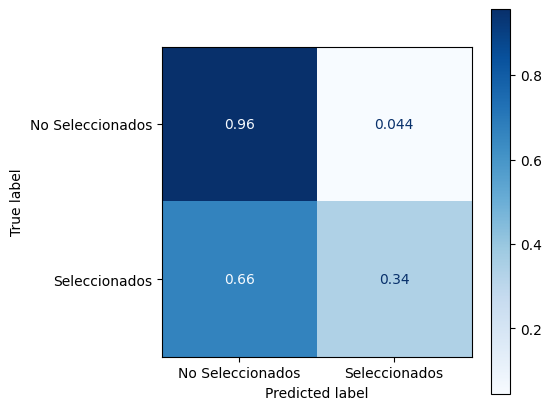

In [73]:
from sklearn import metrics
import matplotlib.pyplot as plt

#Plot a confussion matrix
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (5, 5));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels , normalize = "true");
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=classes);
    cm.plot(cmap = 'Blues', ax = ax)

classes = ["No Seleccionados", "Seleccionados"]
plot_confusion_matrix(y_test, y_pred_tree, classes)

In [74]:
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5449
           1       0.33      0.34      0.34       355

    accuracy                           0.92      5804
   macro avg       0.65      0.65      0.65      5804
weighted avg       0.92      0.92      0.92      5804



###Resultado Árbol de decisión

Vemos que el árbol obtiene muy buenos resultados en Accuracy, esto es por que al mirar los resultados de manera global acierta a la mayoría de los casos. Sin embargo dado el desbalance que hay en las clases, esta precisión no necesariamente es indicadora de un buen resultado. Vemos que para el caso de seleccionados nacionales, que es la clase minoritaria las metricas no superan los 0,35 puntos, menos de la mitad de los jugadores seleccionados fueron bien clasificados(mal recall) y de todas las personas que clasifico como seleccionados, 200 de ellas no lo eran (mala precisión). 

In [75]:
svc_pipe.fit(X_train, y_train)
y_pred_svc = svc_pipe.predict(X_test)

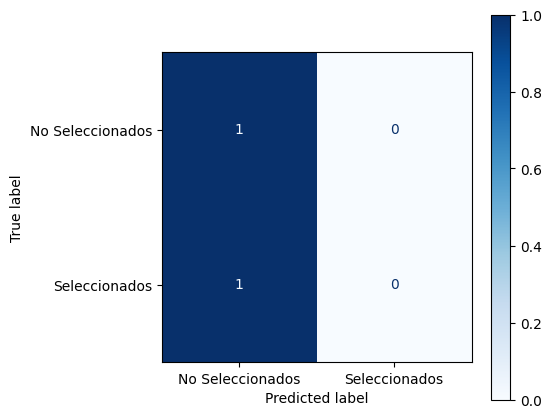

In [76]:
plot_confusion_matrix(y_test, y_pred_svc, classes)

In [77]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5449
           1       0.00      0.00      0.00       355

    accuracy                           0.94      5804
   macro avg       0.47      0.50      0.48      5804
weighted avg       0.88      0.94      0.91      5804



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Resultados SVC

Se repite los resultados de Accuracy, obteniendo un buen 94% pero que como ya sabemos que las clases estan desbalanceadas, estos valores no son representativos de la calidad del resultado.
Aqui el modelo tomo la decisión de asignar a todos los casos como no seleccionados, teniendo una precisión y recall de 0.0 para el caso de selecionados nacionales. El peor resultado posible.

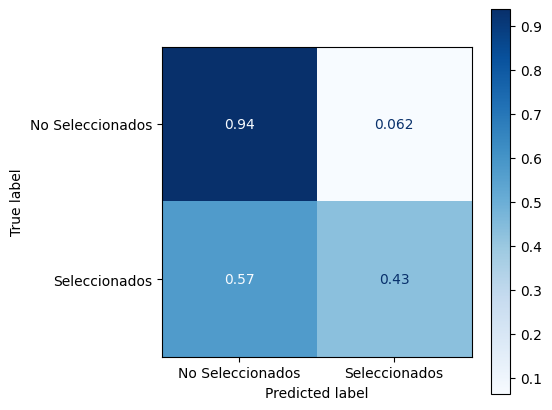

In [78]:
nb_pipe.fit(X_train, y_train)
y_pred_nb = nb_pipe.predict(X_test)

plot_confusion_matrix(y_test, y_pred_nb, classes)

In [79]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      5449
           1       0.31      0.43      0.36       355

    accuracy                           0.91      5804
   macro avg       0.64      0.68      0.66      5804
weighted avg       0.92      0.91      0.91      5804



###Resultados Naive Bayes

Por ultimo se observa el modelo NB, el cual supera las metricas de los otros 3 modelos, es el que mejor predice la clase Seleccionado, logrando identificar al 43% de los seleccionados. Estos números siguen siendo muy bajos, esto indica que las caracteristicas que estamos usando no permiten reconocer un patron marcado entre las clases. Se podria pensar en hacer una seleccion de caracteristicas, buscando eliminar ruido y dejando solo aquellas que realmente aporten a la clasificación.

## 1.2 Predicción de posiciones de jugadores [2 puntos]

<p align="center">
  <img src="https://pbs.twimg.com/media/E1rfA1aWEAYU6Ny.jpg" width="500">
</p>

En una nueva jornada de desmesuradas transacciones deportivas, Renacín escuchó a sus colegas discutir acerca de que el precio de cada jugador depende en gran medida de la posición en la cancha en la que juega. Y además, que hay bastantes jugadores nuevos que no tienen muy claro en que posición verdaderamente brillarían, por lo que actualmente puede que actualmente estén jugando en posiciones sub-optimas. 

Viendo que los resultados del primer análisis no son tan esperanzadores, el corporeo los comanda a cambiar su tarea: ahora, les solicita que construyan un clasificador enfocado en predecir la mejor posición de los jugadores en la cancha según sus características. 

Para lograr esto, primero, les pide que etiqueten de la siguiente manera los valores que aparecen en el atributo ```Club_Position```, pidiendo que agrupen los valores en los siguientes grupos:

**Nota**:  Renacín les recalca que **no deben utilizar los valores ```Sub``` y ```Res``` de esta columna**.

```python
ataque = ['ST', 'CF'] 
central_ataque = ['RW', 'CAM', 'LW'] 
central = ['RM', 'CM', 'LM'] 
central_defensa = ['RWB', 'CDM', 'LWB']
defensa = ['RB', 'CB', 'LB']
arquero = ['GK']
```

Cabe señalar que al igual como lo realizado con la clasificación binaria, deberá justificar en base a la [guía](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) la elección del clasificador y se deben comentar los resultados obtenidos en la clasificación.

**Nota:** Clasifique solamente con las clases señaladas, si observa mas clases eliminelas de la clasficación.

**To-Do**:

- [ ] Aplique las etiquetas descritas anteriormente en cada uno de los valores señalados en esta sección.
- [ ] Cuente cuantos por clase quedan.
- [ ] Entrene el nuevo pipeline y ejecute una evaluación de este.  
- [ ] Comente los resultados obtenidos.

**Respuesta:**

In [21]:
ataque = ['ST', 'CF'] 
central_ataque = ['RW', 'CAM', 'LW'] 
central = ['RM', 'CM', 'LM'] 
central_defensa = ['RWB', 'CDM', 'LWB']
defensa = ['RB', 'CB', 'LB']
arquero = ['GK']

In [22]:
def posicion(x):
    if x in ataque:
        return 'ataque'
    if x in central_ataque:
        return 'central_ataque'
    if x in central:
        return 'central'
    if x in central_defensa:
        return 'central_defensa'
    if x in defensa:
        return 'defensa'
    if x in arquero:
        return 'arquero'
    else:
        return 'otro'   

In [23]:
df_players['Club_Position'] = df_players['Club_Position'].apply(posicion)

In [24]:
df_players = df_players.drop(df_players[df_players['Club_Position'] == 'otro'].index)

In [25]:
df_players['Club_Position'].value_counts()

defensa            1180
central             907
arquero             632
central_ataque      581
ataque              430
central_defensa     209
Name: Club_Position, dtype: int64

In [26]:
# Holdout

#Creamos los Sets de datos con sus etiquetas
features = df_players.drop(columns=["Club_Position"])
labels = df_players.loc[:, "Club_Position"]

#Realizaremos la división solo en 2 grupos, usando 2/3 de train y 1/3 de Test
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.33, shuffle=True, stratify=labels, random_state=42
)
#Como parametro se tratara de mantener las proporciones en ambas particiones.

In [27]:
#Atributos categoricos sin ordinalidad 
onehot =  ['Nationality', 
           'Preffered_Foot',
           'Weak_foot',
           'Skill_Moves'
          ]
#atributos categoricos que si poseen un orden
catord =  ['Work_Rate'
          ]
#orden de los atributos categoricos ordinales
ordinal_cat = [['Low / Low',
               'Low / Medium',
               'Low / High',
               'Medium / Low',
               'Medium / Medium',
               'Medium / High',
               'High / Low',
               'High / Medium',
               'High / High'
          ]]

#Para aquellos atributos que siguen distribuciones bimodales
lognornal = ['Ball_Control',
             'Dribbling',
             'Marking',
             'Sliding_Tackle',
             'Standing_Tackle',
             'Interceptions',
             'Crossing',
             'Short_Pass',
             'Long_Pass',
             'Stamina',
             'Penalties'
             ]


#Todos los atributos que siguen una distribción estandar o similar
standard = ['Height',
            'Weight',
            'Age',
            'Aggression',
            'Reactions',
            'Vision',
            'Composure',
            'Acceleration',
            'Speed',
            'Strength',
            'Balance',
            'Agility',
            'Jumping',
            'Curve',
            'Volleys',
            'Heading',
            'Shot_Power'
            ] 

#atributos cuya distribución no sigue una curva estandar y solo queremos distribuir los datos entre 0 y 1
minmax = ['Finishing',
          'Long_Shots',
          'Freekick_Accuracy'
           ]
#Para aquellos datos que siguen una distribución normal pero poseen valores atipicos o outlayers
robusta = [] #No se encontraron atributos con outlyers tan marcados

#atributos que no se transformaran
passthrough = [ 'National_Position',
                #'Club_Position'
                #,'Name'     Esta variable no se usará
                ]

In [29]:
transformer = ColumnTransformer(
    transformers=[
        ('passthrough','passthrough', passthrough),
        ('onehotencoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), onehot),  # 
        ('ordinales', OrdinalEncoder(categories = ordinal_cat), catord),  #
        ('lognormal', log_transform, lognornal ),  #  
        ('standard', StandardScaler(), standard),  # 
        ('minmax', MinMaxScaler(), minmax),   # 
    ])



In [30]:
#Pipeline del Arbol de decisión
tree_pipe = Pipeline([
     ("preprocesamiento", transformer),
     ("tree", DecisionTreeClassifier(criterion="entropy"))
    ])

#Pipeline para NaiveBayes
nb_pipe = Pipeline([
        ("preprocesamiento", transformer), 
        ("nb", BernoulliNB())
    ])

#Pipeline para Support Vector Classification
svc_pipe = Pipeline([
    ("preprocesamiento", transformer), 
    ("svc", SVC())
    ])

In [31]:
pip = Pipeline([('Preprocesing', transformer)])
df_procesado = pd.DataFrame(pip.fit_transform(X_train))

In [35]:
classes = ["arquero","ataque","central", "central_ataque","central_defensa","defensa"]

Repetimos el proceso igual que para el caso de clasificación binaria, esta vez con las 6 clases correspondientes a las diferentes posiciones.

In [28]:
y_test.value_counts()

defensa            389
central            299
arquero            209
central_ataque     192
ataque             142
central_defensa     69
Name: Club_Position, dtype: int64

                 precision    recall  f1-score   support

        arquero       1.00      1.00      1.00       209
         ataque       0.70      0.71      0.71       142
        central       0.48      0.47      0.48       299
 central_ataque       0.36      0.38      0.37       192
central_defensa       0.19      0.20      0.19        69
        defensa       0.79      0.76      0.78       389

       accuracy                           0.64      1300
      macro avg       0.59      0.59      0.59      1300
   weighted avg       0.65      0.64      0.64      1300



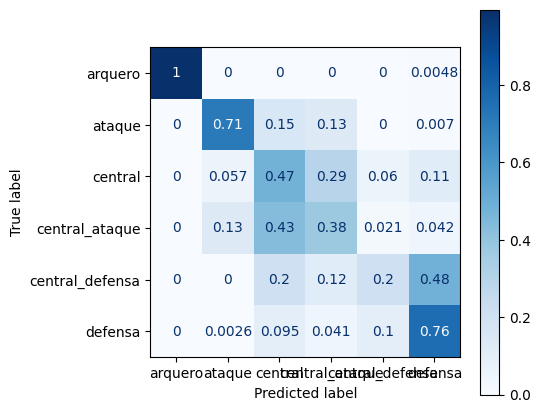

In [36]:
tree_pipe = tree_pipe.fit(X_train, y_train)
y_pred_tree = tree_pipe.predict(X_test)
plot_confusion_matrix(y_test, y_pred_tree, classes)
print(classification_report(y_test, y_pred_tree))

### Análisis Árbol multiclase
Los resultados del arbol son muy buenos para algunas posiciones y malos para otras. En este caso los arqueros los precide casi a la perfección sin cometer errores, luego su mejor desempeño es en la posición ataque y defensa, con muy buenos resultados. Su peor desempeño esta en las 3 posiciones centrales, las cuales confunde con mayor regularidad, siendo el central defensa el que posee menor desempeño, pues los etiqueta como defensa.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

        arquero       1.00      1.00      1.00       209
         ataque       0.76      0.81      0.78       142
        central       0.53      0.74      0.61       299
 central_ataque       0.80      0.02      0.04       192
central_defensa       0.00      0.00      0.00        69
        defensa       0.74      0.98      0.84       389

       accuracy                           0.71      1300
      macro avg       0.64      0.59      0.55      1300
   weighted avg       0.70      0.71      0.65      1300



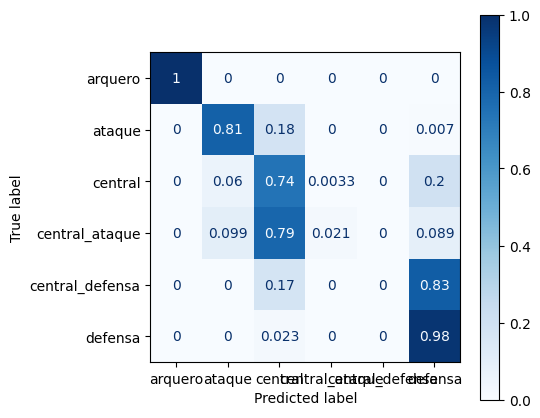

In [37]:
svc_pipe.fit(X_train, y_train)
y_pred_svc = svc_pipe.predict(X_test)
plot_confusion_matrix(y_test, y_pred_svc, classes)
print(classification_report(y_test, y_pred_svc))

###Análisis SVC Multiclase

Vemos que para el caso multiclase los resultados son mucho mejores, tiene una precisión perfecta para el caso de los arqueros tambien pero metricas mucho mejores para defensa y ataque. Por ultimo las clases centrales siguen siendo las más dificiles de predecir,mejoro bastante la predicción del central pero ahorase omitio por completo la clase central defensa, la cual no clasifico en ningun caso correctamente.

                 precision    recall  f1-score   support

        arquero       1.00      1.00      1.00       209
         ataque       0.43      0.54      0.48       142
        central       0.44      0.42      0.43       299
 central_ataque       0.42      0.41      0.41       192
central_defensa       0.20      0.12      0.15        69
        defensa       0.70      0.72      0.71       389

       accuracy                           0.60      1300
      macro avg       0.53      0.53      0.53      1300
   weighted avg       0.59      0.60      0.59      1300



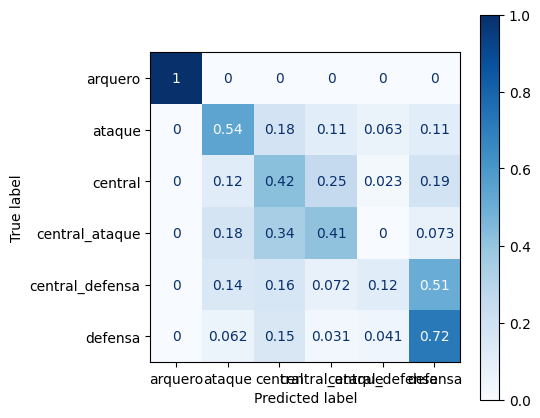

In [38]:
nb_pipe.fit(X_train, y_train)
y_pred_nb = nb_pipe.predict(X_test)

plot_confusion_matrix(y_test, y_pred_nb, classes)
print(classification_report(y_test, y_pred_nb))

###Análisis NB multiclase

Por ultimo para cerrar vemos los resultados del caso multiclase para NB, aquí como ya es habitual se predijo de manera perfecta a los arqueros, para el resto de posiciones obtuvo peores resultados que el árbol, y se repite que la posición central defensa es en la que se cometen más errores al ser muy parecida al defensa.

Al igual que para el caso binario, hacer PCA podria ayudar a reducir el ruido, y buscar mejores caracteristicas para entregarle al dataset.

## 1.3 Predicción de Sueldos [2 puntos]

<p align="center">
  <img src="https://media.giphy.com/media/3oEjHWtHAFcOKS4iA0/giphy.gif" width="460">
</p>

Queriendo ahondar aún más en el mercado del balompíe, Renacin, logra obtener (de una manera no muy formal) los sueldos de múltiples futbolistas y los guarda en el archivo ```sueldos.csv```. Con ellos les solicita que generen un regresor que les permita predecir el sueldo de los futbolistas en base a las características de los pichichis, esto, debido a su motivación por invertir y/o realizar especulación sobre los sueldos de jugadores.

Renacin es claro señalando que deben seguir utilizando la [guía](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) y comenten cada uno de los pasos realizados, para obtener su regresión lineal. Señalándoles que no aceptara un $R^2$ inferior a 0.35 para el modelo solicitado.

Para esta parte usted tiene total libertad en la generación del regresor, la unica exigencia es que utilice un pipeline para generar la regresión y utilice la metrica $R^2$ para medir el rendimiento de esta.

**To-Do**:

- [ ] Explique en que consiste la métrica $R^2$
- [ ] Generar un pipeline para la regresión.
- [ ] Obtener un regresor con un $R^2$ superior a  $0.35$.
- [ ] Comente sus resultados y si es posible mejorar los resultados obtenidos. ¿Se necesitarían más datos o otros tipos de características o una combinación de ambos?

**Respuesta**

In [40]:
df_sueldos = pd.read_csv("/content/salarios.csv")
df_players = pd.read_csv("/content/stats_players.csv")

In [41]:
df_players['Club_Position'] = df_players['Club_Position'].apply(posicion)

In [42]:
df_players['National_Position'] = df_players['National_Position'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [43]:
df_players = df_players.astype(
    {
        'Nationality': 'category',
        'National_Position': 'category',
        'Club_Position': 'category',
        'Preffered_Foot': 'category',
        'Work_Rate': 'category'
    }
)

In [44]:
df_regresion = pd.merge(df_players, df_sueldos, left_on='Name', right_on='Player', how='inner')

In [45]:
df_regresion = df_regresion.drop(columns=['Player', 'Unnamed: 0'])

In [46]:
minmax = [
    'Ball_Control',
    'Dribbling',
    'Marking',
    'Sliding_Tackle',
    'Standing_Tackle',
    'Interceptions',
    'Crossing',
    'Short_Pass',
    'Long_Pass',
    'Stamina',
    'Heading',
    'Shot_Power',
    'Finishing',
    'Long_Shots',
    'Curve',
    'Freekick_Accuracy',
    'Penalties'
]

onehot = [
    'Nationality',
    'Club_Position',
    'Preffered_Foot',
    'Skill_Moves'
]

categorical = [
    'Weak_foot',
    'Work_Rate'
]

log = [
   'Age' 
]

passthrough = [
    'National_Position'
]

noseusa = [
    'Name',
    'Weekly Salary'
]

standard = list(set(df_regresion.columns) - set(log) - set(categorical) - set(minmax) - set(onehot) - set(passthrough) - set(noseusa))

In [47]:
def log_transform(x):
    return np.log(x + 1)

In [48]:
transformer = ColumnTransformer([
    ('passthrough', 'passthrough', passthrough),
    ('Scaled', StandardScaler(), standard),
    ('minmax', MinMaxScaler(), minmax),
    ('onehot', OneHotEncoder(sparse = False, drop='first'), onehot),
    ('categorical', OrdinalEncoder(), categorical),
    ('log', FunctionTransformer(func = log_transform), log)
]).set_output(transform='pandas')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [49]:
from sklearn.svm import SVR
from sklearn.linear_model import Lasso

In [50]:
pipe = Pipeline([('preprocesamiento', transformer),
                 ('regresor', Lasso())])
#Se escogió Lasso() puesto que debido al encoder sobre la nacionalidad, existen
#muchas columnas quenquedan con 0 y segun el mapa de sklearn este tipo de regresores seria el ideal

In [51]:
features = df_regresion.drop(columns=['Name', 'Weekly Salary'])
labels = df_regresion.loc[:, 'Weekly Salary']


X_train, X_test, y_train, y_test  = train_test_split(
    features, labels, shuffle=True, train_size=0.7, random_state= 0
)

In [52]:
#Se realizó este while para que exista un conjunto de entrenamiento 
#que contenga todas las nacionalidades y así aplicar OneHot Encoder de buena forma
#se hace medianta la busqueda de un random state que haga que el conjunto de entrenamiento
#contenga todas las nacionalidades del dataset
random_state_89 = 0

while len(X_train['Nationality'].unique()) != len(df_regresion['Nationality'].unique()):

    X_train, X_test, y_train, y_test  = train_test_split(
        df_regresion.drop(columns=['Name', 'Weekly Salary']), df_regresion['Weekly Salary'], shuffle=True, train_size=0.7, random_state= random_state_89
    )
    random_state_89 += 1
random_state_89 -= 1   

In [53]:
random_state_89

2801

In [54]:
X_train, X_test, y_train, y_test  = train_test_split(
    df_regresion.drop(columns=['Name', 'Weekly Salary']), df_regresion['Weekly Salary'], shuffle=True, train_size=0.7, random_state= random_state_89
)

In [55]:
pipe.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['National_Position']),
                                                 ('Scaled', StandardScaler(),
                                                  ['Reactions', 'Weight',
                                                   'Composure', 'Balance',
                                                   'Aggression', 'Strength',
                                                   'Jumping', 'Agility',
                                                   'Volleys', 'Height',
                                                   'Vision', 'Acceleration',
                                                   'Speed']),
                                                 ('minmax', MinMaxScaler(),
                                                  ['Ball_Control', 'Dribbling',
                                                   'Marking'...
                                                   'Shot_Power', 'Finishing',
                                                   'Long_Shots', 'Curve',
                                                   'Freekick_Accuracy',
                                                   'Penalties']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['Nationality',
                                                   'Club_Position',
                                                   'Preffered_Foot',
                                                   'Skill_Moves']),
                                                 ('categorical',
                                                  OrdinalEncoder(),
                                                  ['Weak_foot', 'Work_Rate']),
                                                 ('log',
                                                  FunctionTransformer(func=<function log_transform at 0x7fcb4c9e7be0>),
                                                  ['Age'])])),
                ('regresor', Lasso())])

In [56]:
y_pred = pipe.predict(X_test)

In [57]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

def evaluate(y_test, y_pred):

    print('MSE:', mean_squared_error(y_test, y_pred), '\n')
    print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))
    print('MAE:', mean_absolute_error(y_test, y_pred))
    print('MedAE:', median_absolute_error(y_test, y_pred), '\n')
    print('R²:', r2_score(y_test, y_pred))
    
    
evaluate(y_test, y_pred)

MSE: 4114918624.440407 

RMSE: 64147.63147958315
MAE: 36076.06277626542
MedAE: 23511.342976393105 

R²: 0.38171502785948486


In [58]:
df_regresion.shape

(1866, 40)

In [59]:
df_regresion['Weekly Salary'].describe()

count    1.866000e+03
mean     5.363130e+04
std      8.193256e+04
min      6.200000e+02
25%      1.413700e+04
50%      2.940400e+04
75%      6.502900e+04
max      1.538905e+06
Name: Weekly Salary, dtype: float64

**Respuesta**:
Como se puede ver de los resultados, este tiene un  R2  de 0.38, lo que quiere decir que no se esta logrando captar mucha variabilidad del modelo con los coeficientes del regresor estimado. Con respecto a otras métricas como lo puede ser el MAE, se puede ver que el promedio del error en la prediccion esta por los 36076 dolares, siendo que el dataset tiene como valor promedio de los sueldos 53631, esto es mas de la mitad de los sueldos promedio en error promedio, por lo que se puede concluir que el regresor entrenado no es muy confiable. Esto se puede deber a distintas razones, ya sea porque solo 1866 datos, valor relativamente bajo para hacer una regresion de este tipo, como también datos más informativos acerca del jugador que puedan relacionarse con su sueldo, como la liga en la que juega, la cantidad de titulos que ha ganado, entre otros, ya que generalmente en los deportes este tipo de caracteristicas son significativas a la hora de fichar a un jugador.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

<p align="center">
  <img src="https://media2.giphy.com/media/l1J3CbFgn5o7DGRuE/giphy.gif">
</p>

<br>
<center>
<img src="https://i.kym-cdn.com/photos/images/original/001/194/195/b18.png" width=100 height=50 />
</center>
<br>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>